# Time Series Forecast : A basic introduction using Python

* Ref: [https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000](https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000)
* Data: 用 AirPassenger

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
from IPython.display import display

## 1. Load data

In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/AirPassengers.csv')
display(df.head())
df.info()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


## Time series 的資料讀入之後，要把 index 設成日期時間格式，然後最好是讀成 pandas series 而不是讀成 pandas dataframe

Month 現在是 string，要把 Month 欄位改成 datetime64 格式，然後設成 index

In [ ]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
display(df.head())

# 把 dataframe 轉成 series
ts = df['#Passengers']
display(ts.head())

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

## 2. Analysis
* 檢查每個時刻是否有 correlation (auto correlation)
* 檢查是不是 stationary
    * Stationary
        * mean, variance 不隨時間而改變
        * auto covariance doesn't depend on time
    * 用 Dickey-Fuller Test 檢查是否是 stationary:
        * null hypothesis: the time series is non- stationary.
        * Test statistics $\lt$ critical value $\rightarrow$ reject null hypothesis
        * $p$-value $\lt$ 0.05 $\rightarrow$ reject null hypothesis
        * ADF < 0 (ADF 就是 test statistics)
* 如果不是 stationary 的話，就要把 trend 和 seasonality 移除
    * transformation: 像是取 log 或是開根號等等
    * differencing: 計算 $y(t)$ 和 $y(t-1)$ 的差
    * decomposition: 拆成 trend, seasonality, residual

In [ ]:
# specify index as string constant
print(ts['1949-01-01'])

# use datetime function
from datetime import datetime
print(ts[(datetime(1949, 1, 1))])

# specify the range
print(ts['1949-01-01':'1949-05-01']) # 會包含 1949-05-01
print(ts[:'1949-05-01']) # 會包含 1949-05-01

# specify year only
print(ts['1949'])

112
112
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64
Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64


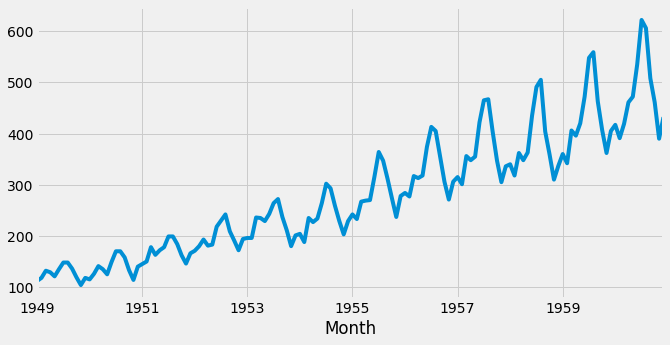

In [ ]:
# 拿到 time series 的第一步分析就是畫圖看分佈
fig, ax = plt.subplots(figsize=(10, 5))
ts.plot(ax=ax)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationary(time_series):
  # determin rolling statistics
  rolling_mean = time_series.rolling(12).mean()
  rolling_std = time_series.rolling(12).std()

  # plot rolling statistics
  fig, ax = plt.subplots(figsize=(10, 5))
  time_series.plot(ax=ax, color='blue', label='original')
  rolling_mean.plot(ax=ax, color='red', label='rolling mean')
  rolling_std.plot(ax=ax, color='black', label='rolling std')
  plt.legend()
  plt.title('Rolling mean and standard deviation')
  plt.show()

  # perform Dickey-Fuller test
  print('Results of Dickey-Fuller test:')
  adf_test = adfuller(time_series, autolag='AIC')
  index = [
    'Test statistics',
    'p-value',
    'Number of lags used',
    'Number of observations used'
  ]
  adf_results = pd.Series(adf_test[:4], index=index)
  for k, v in adf_test[4].items():
    adf_results[f'Critical value ({k})'] = v
  print(adf_results)

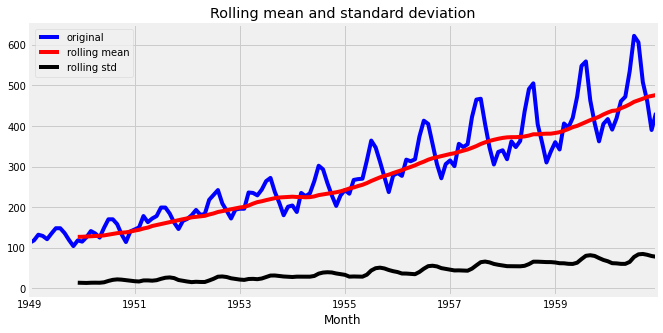

Results of Dickey-Fuller test:
Test statistics                  0.815369
p-value                          0.991880
Number of lags used             13.000000
Number of observations used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [ ]:
test_stationary(ts)

* 由圖知道 mean 隨著時間而增加，由 Dickey-Fuller 也知道 test statistics > crritical value 且 $p$-value > 0.05，所以 time series 是 non-stationary 的。

### 只移除 trend

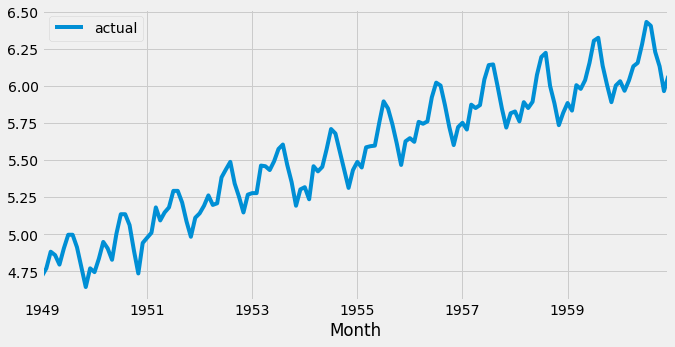

In [ ]:
def plot_time_series(time_series, predictions=None):
  fig, ax = plt.subplots(figsize=(10, 5))
  time_series.plot(ax=ax, label='actual')
  if predictions is not None:
    predictions.plot(ax=ax, color='red', label='predicted')
  plt.legend()
  plt.show()

# transformation 的方法有很多種，像是取 log 或是開根號等等
ts_log = np.log(ts)
plot_time_series(ts_log)

* 取了 log 之後仍然看得出來有 trend 但是看 y 軸的話就知道這個 trend 變小很多了。
* 可以試著用 smoothing 或是 aggression，像是 rolling 或 moving average 之類的來找出 trend 然後再把這個 trend 從原來的數據中減掉，就可以得到沒有 trend 的分佈

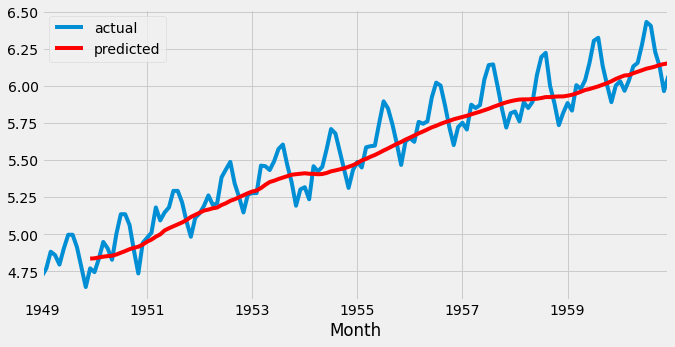

In [ ]:
# 這邊用 moving average 來做 smoothing
moving_avg = ts_log.rolling(12).mean()
plot_time_series(ts_log, moving_avg)
# fig, ax = plt.subplots(figsize=(10, 5))
# ts_log.plot(ax=ax)
# moving_avg.plot(ax=ax, color='red')
# plt.show()

In [ ]:
ts_log_moving_avg_diff = ts_log - moving_avg # 把 moving average 從數據中減掉，就會得到沒有 trend 的分佈
ts_log_moving_avg_diff.head(15)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
Name: #Passengers, dtype: float64

因為 moving average 是用 12 當週期，所以前面 11 個 row 的值會是空的，當然在被減去的時候就沒東西可以減，所以是 NaN。要把這些 NaN 的部分剔除掉

In [ ]:
ts_log_moving_avg_diff.dropna(inplace=True)
ts_log_moving_avg_diff.head() # 從 1949-12-01 開始

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64

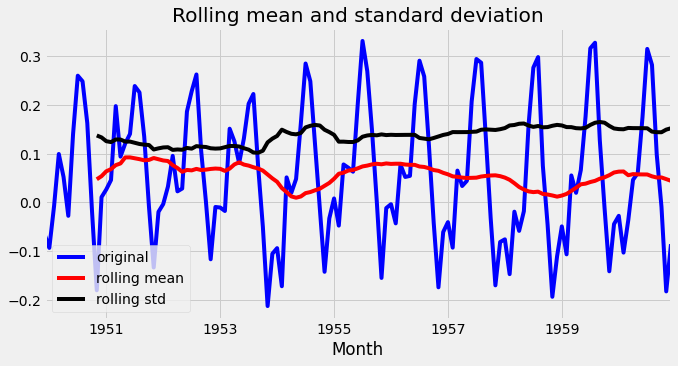

Results of Dickey-Fuller test:
Test statistics                 -3.162908
p-value                          0.022235
Number of lags used             13.000000
Number of observations used    119.000000
Critical value (1%)             -3.486535
Critical value (5%)             -2.886151
Critical value (10%)            -2.579896
dtype: float64


In [ ]:
test_stationary(ts_log_moving_avg_diff) # 測試看看是否是 stationary 的

* 看圖就知道已經差不多沒有 trend 了，test statistic 也比 critical value 5%, 10% 都還小，$p$-value 也是 < 0.05，所以 Dickey-Fuller test 也可以 reject null hypothesis，因此現在的分佈是 stationary 的

* 用另一種 moving average: exponentially weighted moving average (EWMA) 來做

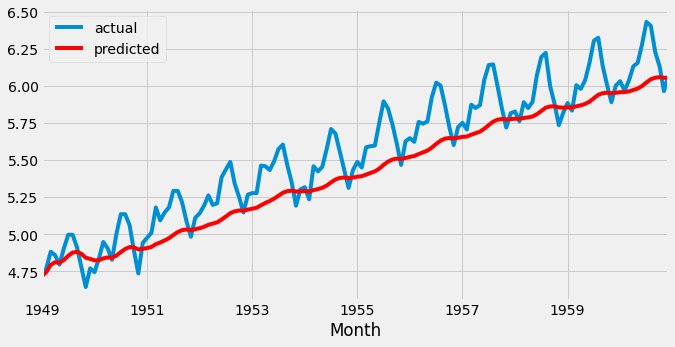

In [ ]:
# 用 exponentially weighted moving average
exp_weighted_avg = ts_log.ewm(halflife=12).mean()
plot_time_series(ts_log, exp_weighted_avg)
# fig, ax = plt.subplots(figsize=(10, 5))
# ts_log.plot(ax=ax)
# exp_weighted_avg.plot(ax=ax, color='red')
# plt.show()

Month
1949-12-01   -0.065494
1950-01-01   -0.093449
1950-02-01   -0.007566
1950-03-01    0.099416
1950-04-01    0.052142
Name: #Passengers, dtype: float64


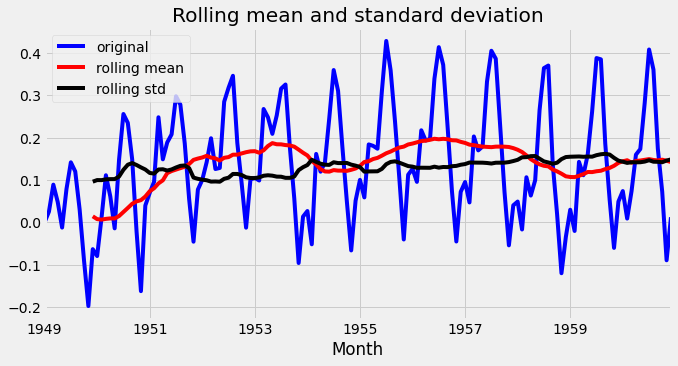

Results of Dickey-Fuller test:
Test statistics                 -3.601262
p-value                          0.005737
Number of lags used             13.000000
Number of observations used    130.000000
Critical value (1%)             -3.481682
Critical value (5%)             -2.884042
Critical value (10%)            -2.578770
dtype: float64


In [ ]:
ts_log_emwa_diff = ts_log - exp_weighted_avg # 把 ewma 從數據中減掉，就會得到沒有 trend 的分佈
print(ts_log_moving_avg_diff.head())

test_stationary(ts_log_emwa_diff)

用 EMWA 的話 test statistics 比 critical value 1% 還要小，所以有 99% 的信心能說這個是 stationary 的

### 移除 trend 和 stationary
* differencing:
    * 計算兩個時間點對應到的值的差值 $y(t=i) - y(t=i-1)$
    * 做幾次 differencing 就是幾個 order 的 differencing
        * d=3 就是 3 階 differencing 表示做三次 differencing
* decomposition: 會同使處理 trend 和 stationary

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64
Month
1949-01-01         NaN
1949-02-01    4.718499
1949-03-01    4.770685
1949-04-01    4.882802
1949-05-01    4.859812
Name: #Passengers, dtype: float64
Month
1949-01-01         NaN
1949-02-01    0.052186
1949-03-01    0.112117
1949-04-01   -0.022990
1949-05-01   -0.064022
Name: #Passengers, dtype: float64


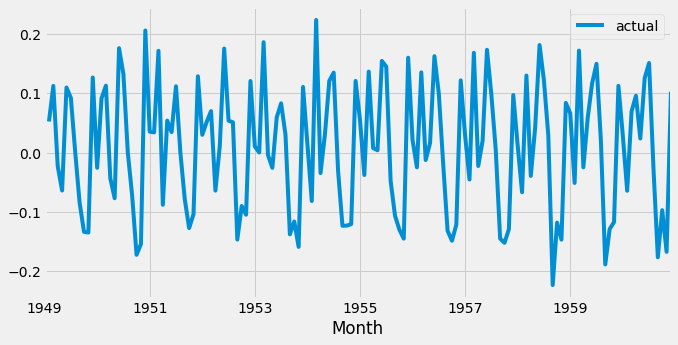

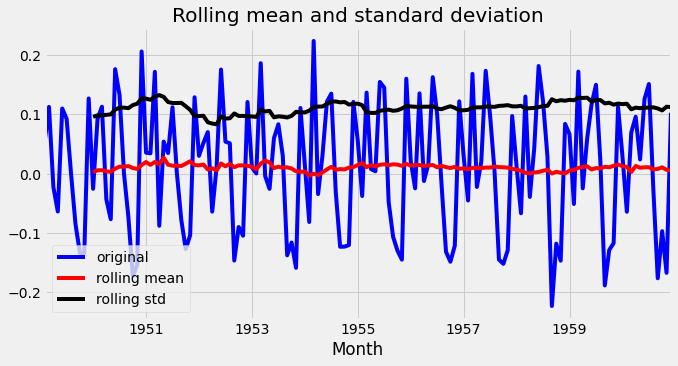

Results of Dickey-Fuller test:
Test statistics                 -2.717131
p-value                          0.071121
Number of lags used             14.000000
Number of observations used    128.000000
Critical value (1%)             -3.482501
Critical value (5%)             -2.884398
Critical value (10%)            -2.578960
dtype: float64


In [ ]:
# first order of differencing
print(ts_log.head())
print(ts_log.shift().head()) # shift(n) 會把原本的資料往下移 n 格，預設是 n=1

ts_log_diff = ts_log - ts_log.shift()
print(ts_log_diff.head()) # 第一 row 會是 NaN
plot_time_series(ts_log_diff)
# fig, ax = plt.subplots(figsize=(10, 5))
# ts_log_diff.plot(ax=ax)
# plt.show()

# 檢查 stationary
ts_log_diff.dropna(inplace=True)
test_stationary(ts_log_diff)

* 看圖知道 rolling mean 和 std 沒什麼變，然後 test statistics < critical value (10%) 所以有 90% 的信心說這個是 stationary 的。
* 但是 $p$-value 仍然 > 0.05 所以不能 reject null hypothesis

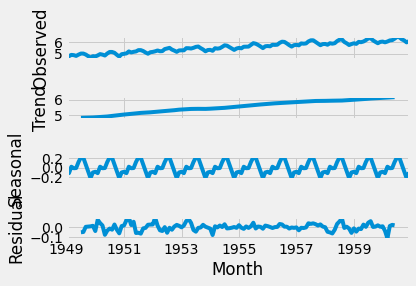

In [ ]:
# 同時處理 trend 和 seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
fig = decomposition.plot() # 圖太小，而且沒辦法直接改尺寸，除非分開畫四張圖
plt.show()

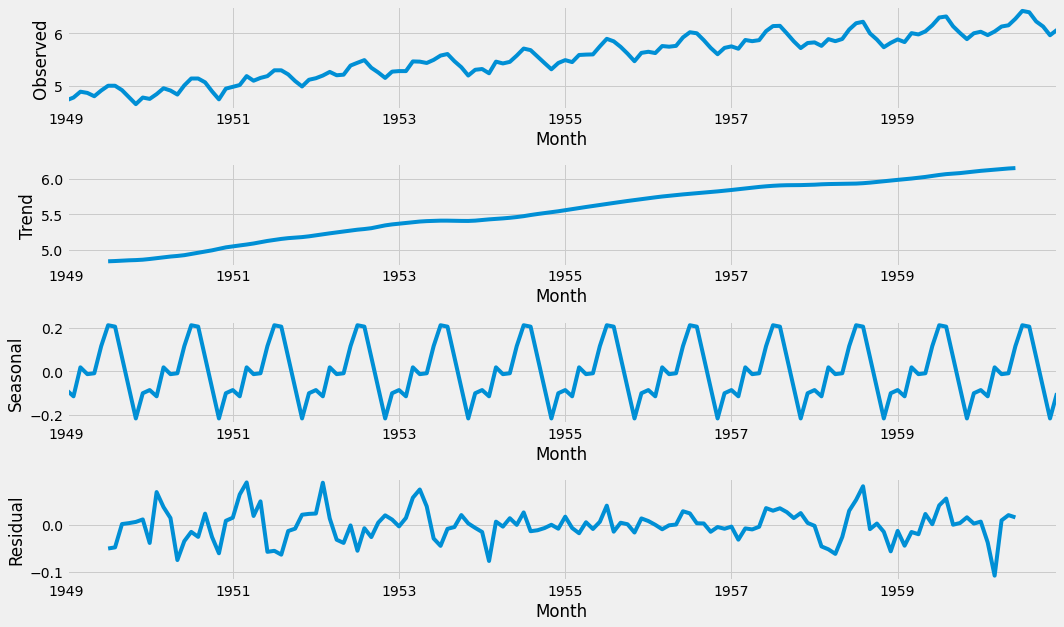

In [ ]:
# 改成單獨畫每張圖
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, ax = plt.subplots(4, 1, figsize=(15, 9))
ts_log.plot(ax=ax[0])
ax[0].set_ylabel('Observed')

trend.plot(ax=ax[1])
ax[1].set_ylabel('Trend')

seasonal.plot(ax=ax[2])
ax[2].set_ylabel('Seasonal')

residual.plot(ax=ax[3])
ax[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
Name: #Passengers, dtype: float64


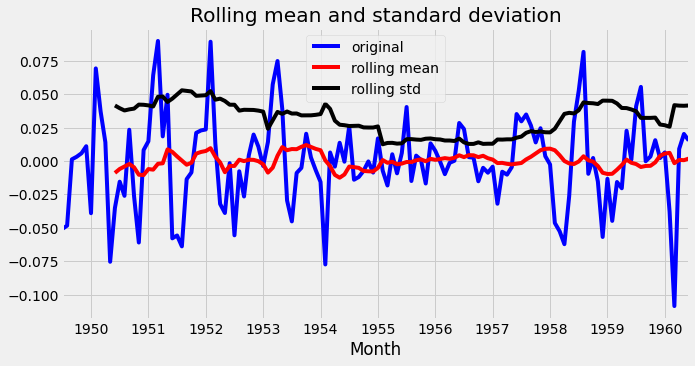

Results of Dickey-Fuller test:
Test statistics               -6.332387e+00
p-value                        2.885059e-08
Number of lags used            9.000000e+00
Number of observations used    1.220000e+02
Critical value (1%)           -3.485122e+00
Critical value (5%)           -2.885538e+00
Critical value (10%)          -2.579569e+00
dtype: float64


In [ ]:
# residual 就是把 trend 和 seasonality 移除後剩下來的
ts_log_decompose = residual
print(ts_log_decompose.head())

ts_log_decompose.dropna(inplace=True)
test_stationary(ts_log_decompose)

因為 test statistics < critical value (1%) 且 $p$-value < 0.05 所以我們可以 reject null hypothesis，說明 residual 的分佈是 stationary

## 3. Forecast
* ARIMA: Auto Regressive Integrated Moving Average
    * 三個參數 p, d, q
        * p: 在 AR 中要用幾個 lags。如果 p=3 就表示用 $y(t), y(t-1), y(t-2)$ 三項 (3 個 lags) 來預測 $y(t+1)$
        * d: 幾階的 differencing (就是要做幾次 differencing)
        * q: 要用幾項來求 moving average。如果 q=3 就表示用 $y(t), y(t-1), y(t-2)$ 來求 MA
    * 用 Autocorrelation Function (ACF) 來估計 q 值，用 Partial Autocorrelation Function (PACF) 來估計 p 值
        * ACF: 看 $X1(t)$ 和 $X1(t-i)$, $X2(t-i)$, ... 之間的 correlation (有直接也有間接)
            * 曲線第一次和 95% confidence level 的交叉，就是 q 值
        * PACF: 只看 $X1(t)$ 和 $X1(t-i)$ 之間的直接 correlation
            * 曲線第一次和 95% confidence level 的交叉，就是 p 值

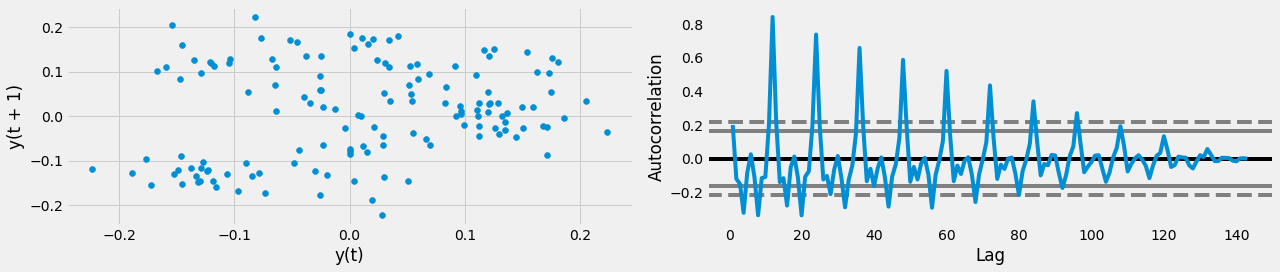

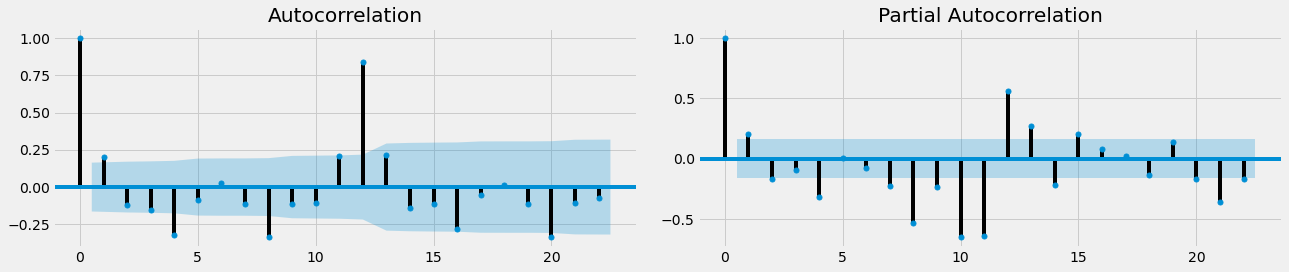

In [ ]:
# 用既有的函數來畫圖
# 畫 lag_plot(), autocorrelation_plot()
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
pd.plotting.lag_plot(ts_log_diff, ax=ax[0])
pd.plotting.autocorrelation_plot(ts_log_diff, ax=ax[1])
plt.tight_layout()
plt.show()

# 畫 plot_acf(), plot_pacf()
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
plot_acf(ts_log_diff, ax=ax[0])
plot_pacf(ts_log_diff, ax=ax[1])
plt.tight_layout()
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


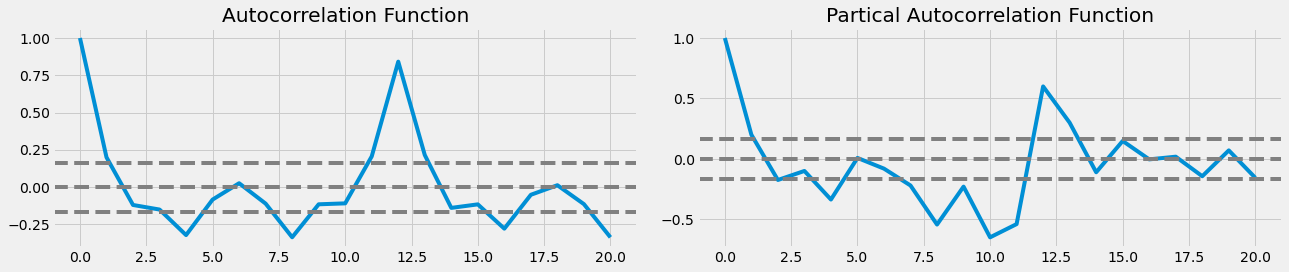

In [ ]:
# 自己手動計算 ACF 和 PACF 然後畫圖
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols') # OLS: ordinary least square

fig, ax = plt.subplots(1, 2, figsize=(18, 4))
ax[0].plot(lag_acf)
ax[0].axhline(y=0, linestyle='--', color='gray')
ax[0].axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray') # 1.96 對應到 95% CL
ax[0].axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
ax[0].set_title('Autocorrelation Function')

ax[1].plot(lag_pacf)
ax[1].axhline(y=0, linestyle='--', color='gray')
ax[1].axhline(y=-1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
ax[1].axhline(y=1.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
ax[1].set_title('Partical Autocorrelation Function')

plt.tight_layout()
plt.show()

* 從藍線和上方虛線的第一次交叉，看得出來 $p, q$ 大概的值是 $p = 2$, $q = 2$
* 我們做過一次 differencing 所以 $d = 1$

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  142
Model:                 ARIMA(2, 1, 0)   Log Likelihood                  96.377
Method:                       css-mle   S.D. of innovations              0.123
Date:                Sat, 13 Jun 2020   AIC                           -184.754
Time:                        01:11:17   BIC                           -172.931
Sample:                    03-01-1949   HQIC                          -179.949
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0003      0.006     -0.055      0.956      -0.012       0.012
ar.L1.D.#Passengers    -0.3871      0.081     -4.779      0.000      -0.546      -0.228
ar.L2.D.#Passeng

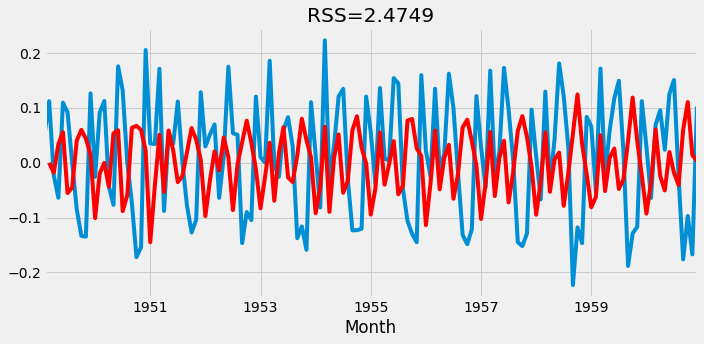

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  142
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 118.206
Method:                       css-mle   S.D. of innovations              0.104
Date:                Sat, 13 Jun 2020   AIC                           -228.412
Time:                        01:11:17   BIC                           -216.588
Sample:                    03-01-1949   HQIC                          -223.607
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -7.703e-05      0.000     -0.289      0.773      -0.001       0.000
ma.L1.D.#Passengers    -0.7220      0.096     -7.492      0.000      -0.911      -0.533
ma.L2.D.#Passeng

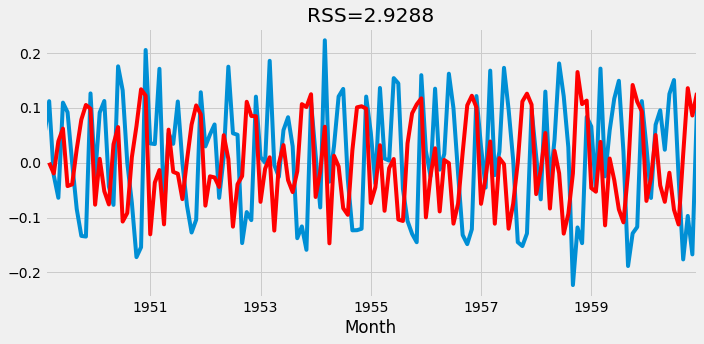

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:          D.#Passengers   No. Observations:                  142
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 121.227
Method:                       css-mle   S.D. of innovations              0.101
Date:                Sat, 13 Jun 2020   AIC                           -230.454
Time:                        01:11:18   BIC                           -212.720
Sample:                    03-01-1949   HQIC                          -223.248
                         - 12-01-1960                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -7.754e-05      0.000     -0.314      0.754      -0.001       0.000
ar.L1.D.#Passengers    -0.5792      0.122     -4.736      0.000      -0.819      -0.339
ar.L2.D.#Passeng

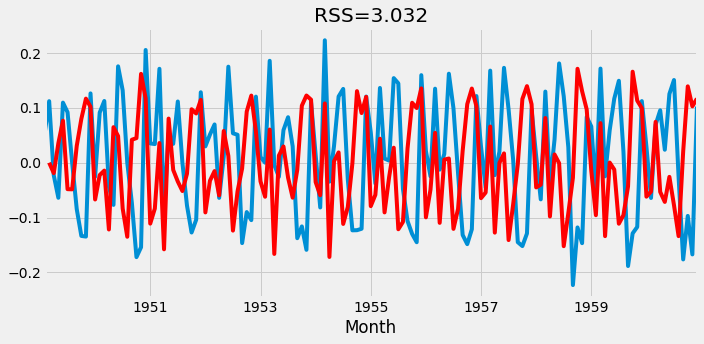

AR AIC=-184.75400041272212, MA AIC=-228.41156486219325, ARIMA AIC=-230.4544919730489


In [ ]:
# 有了 p, d, q 的值後，就可以看各種可能的 (p, d, q) 組合來找出最好的結果
from statsmodels.tsa.arima_model import ARIMA

def plot_model_prediction(time_series, model_fitted):
  predictions = model_fitted.fittedvalues
  residual = (predictions - time_series).dropna() # 要把 NaN 的 row 移除，不然算 RSS 時就變 NaN
  rss = sum(residual**2) # residual sum of square (RSS)
  rss = round(rss, 4)
  fig, ax = plt.subplots(figsize=(10, 5))
  time_series.plot(ax=ax)
  predictions.plot(ax=ax, color='red')
  # ax.plot(time_series)
  # ax.plot(predictions, color='red')
  ax.set_title(f'RSS={rss}')
  plt.tight_layout()
  plt.show()

# AR model
model_ar = ARIMA(ts_log_diff, order=(2, 1, 0))
model_fitted_ar = model_ar.fit(disp=-1)
print(model_fitted_ar.summary())
plot_model_prediction(ts_log_diff, model_fitted_ar)

# MA model
model_ma = ARIMA(ts_log_diff, order=(0, 1, 2))
model_fitted_ma = model_ma.fit(disp=-1)
print(model_fitted_ma.summary())
plot_model_prediction(ts_log_diff, model_fitted_ma)

# ARIMA model
model_arima = ARIMA(ts_log_diff, order=(2, 1, 2))
model_fitted_arima = model_arima.fit(disp=-1)
print(model_fitted_arima.summary())
plot_model_prediction(ts_log_diff, model_fitted_arima)

print(f'AR AIC={model_fitted_ar.aic}, MA AIC={model_fitted_ma.aic}, ARIMA AIC={model_fitted_arima.aic}')

* 上面三個模型中，RSS 最小的是 AR model，但是這邊我仍然繼續使用 ARIMA，因為 ARIMA 的 AIC 是最小的。
* 這裡 AR, MA, 和 ARIMA 是預測 ts_log_diff 的結果，所以得到的預測值要先反推 diff 前的數值，然後再取 exponential 來得到 ts 的預測結果

|原始數列|diff 數列 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|預測diff數列|反推 diff 前的數列 &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp; &nbsp;|
|---:|---:|---:|---:|
|$y(t_0)$|NaN|NaN|$x$|
|$y(t_1)$|$y(t_1)-y(t_0)$|$\hat{y}(t_1)$|$x+\hat{y}(t_1)$|
|$y(t_2)$|$y(t_2)-y(t_1)$|$\hat{y}(t_2)$|$x+\hat{y}(t_1)+\hat{y}(t_2)$|
|$y(t_3)$|$y(t_3)-y(t_2)$|$\hat{y}(t_3)$|$x+\hat{y}(t_1)+\hat{y}(t_2)+\hat{y}(t_3)$|
|$y(t_4)$|$y(t_4)-y(t_3)$|$\hat{y(}t_4)$|$x+\hat{y}(t_1)+\hat{y}(t_2)+\hat{y}(t_3)+\hat{y}(t_4)$|


Month
1949-03-01   -0.000078
1949-04-01   -0.019059
1949-05-01    0.035480
1949-06-01    0.076548
1949-07-01   -0.048302
                ...   
1960-08-01   -0.133914
1960-09-01    0.020196
1960-10-01    0.139153
1960-11-01    0.102713
1960-12-01    0.116836
Length: 142, dtype: float64
Month
1949-03-01   -0.000078
1949-04-01   -0.019137
1949-05-01    0.016343
1949-06-01    0.092891
1949-07-01    0.044589
                ...   
1960-08-01   -0.165704
1960-09-01   -0.145508
1960-10-01   -0.006355
1960-11-01    0.096358
1960-12-01    0.213194
Length: 142, dtype: float64
Month
1949-01-01    0.000000
1949-02-01    0.000000
1949-03-01   -0.000078
1949-04-01   -0.019137
1949-05-01    0.016343
                ...   
1960-08-01   -0.165704
1960-09-01   -0.145508
1960-10-01   -0.006355
1960-11-01    0.096358
1960-12-01    0.213194
Length: 144, dtype: float64
Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882724
1949-04-01    4.840675
1949-05-01    4.812134
                ..

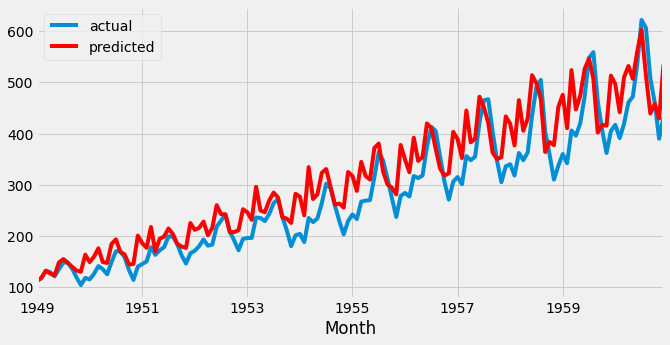

In [ ]:
predictions_arima = model_fitted_arima.fittedvalues # 預測diff數列
print(predictions_arima) # 會少掉 1949-01-01 和 1949-02-01 的預測，因為用了 p = 2, q = 2

predictions_arima_cumsum = predictions_arima.cumsum() # 反推 diff 前的數列
print(predictions_arima_cumsum)

# predictions_arima_cumsum 缺 1949-01-01 和 1949-02-01 兩項，要先補起來
from datetime import datetime
predictions_arima_cumsum[datetime(1949, 2, 1)] = 0
predictions_arima_cumsum[datetime(1949, 1, 1)] = 0
predictions_arima_cumsum.sort_index(inplace=True)
print(predictions_arima_cumsum) # 缺的兩項補回來了

# 要把 predictions_arima_cumsum 加回 ts_log 中
predictions_arima_log = ts_log.add(predictions_arima_cumsum) # ts_log 就是 x
print(predictions_arima_log) # 加回 ts_log 後的結果

predictions_arima_exp = np.exp(predictions_arima_log)
print(predictions_arima_exp) # 這個才是原始的 time series 用 ARIMA 來預測結果

plot_time_series(ts, predictions_arima_exp)
# fig, ax = plt.subplots(figsize=(10, 5))
# ts.plot(ax=ax, label='actual')
# predictions_arima.plot(ax=ax, color='red', label='predicted')
# plt.legend()
# plt.show()